# Определение параметров, влияющих на успешность игры

**Описание проекта**  
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Данные представлены до 2016 года, необходимо спланировать рекламную кампанию на 2017 год на основании расчетов.   

Цель работы: определить слагаемые успеха продаж игры.

Задачи:
1. Исследовать данные, преобразовать типы и обработать пропуски.
2. Провести исследовательский анализ данных за актуальный период - определить наиболее востребованные игровые жанры и платформы.
3. Составить портрет среднего пользователя по крупным регионам (Северная Америка, Япония, Европа) на основании данных о продажах игр.
4. Проверить две статистические гипотезы - равенство средних пользователских рейтингов для платформ PC и XOne и равенство средних пользователских рейтингов для жанров экшен и спорт.


## Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, pearsonr, ttest_ind

In [2]:
data = pd.read_csv("/datasets/games.csv")
pd.set_option('max_columns', None)
#изучение данных в таблице
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 16715 entries, 0 to 16714

Data columns (total 11 columns):

 #   Column           Non-Null Count  Dtype  

---  ------           --------------  -----  

 0   Name             16713 non-null  object 

 1   Platform         16715 non-null  object 

 2   Year_of_Release  16446 non-null  float64

 3   Genre            16713 non-null  object 

 4   NA_sales         16715 non-null  float64

 5   EU_sales         16715 non-null  float64

 6   JP_sales         16715 non-null  float64

 7   Other_sales      16715 non-null  float64

 8   Critic_Score     8137 non-null   float64

 9   User_Score       10014 non-null  object 

 10  Rating           9949 non-null   object 

dtypes: float64(6), object(5)

memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# Проверка на дубликаты
data.duplicated().sum()

0

## Подготовьте данные

In [4]:
# приведение названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.tail()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN


Год выпуска следует привести к целочисленному типу и оценки пользователей с численному с плавающей запятой, остальные столбцы без изменений.

In [5]:
# функция, чтобы не затрагивать строковый тип данных в столбце "user_score"
def convert2float(data):
    try:
        a = float(data)
        return a
    except:
        return data
        

In [6]:
data["year_of_release"] = data["year_of_release"].convert_dtypes()
data["user_score"] = data["user_score"].apply(convert2float)

Так как нас интересуют данные за актуальный период, удалим те столбцы, где информации о годе выпуска нет вообще.  
Также удалим две игры без названия и жанра.

In [7]:
data.dropna(subset=["year_of_release"], inplace=True)
data.dropna(subset=["name"], inplace=True)

Так как оценку критиков и пользователей и рейтинг нельзя получить из других столбцов, но доля пропусков в них велика, пустые значения предлагается оставить.

In [8]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>

Int64Index: 16444 entries, 0 to 16714

Data columns (total 11 columns):

 #   Column           Non-Null Count  Dtype  

---  ------           --------------  -----  

 0   name             16444 non-null  object 

 1   platform         16444 non-null  object 

 2   year_of_release  16444 non-null  Int64  

 3   genre            16444 non-null  object 

 4   na_sales         16444 non-null  float64

 5   eu_sales         16444 non-null  float64

 6   jp_sales         16444 non-null  float64

 7   other_sales      16444 non-null  float64

 8   critic_score     7983 non-null   float64

 9   user_score       9839 non-null   object 

 10  rating           9768 non-null   object 

dtypes: Int64(1), float64(5), object(5)

memory usage: 1.5+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


К пропускам могли привести ошибки выгрузки данных.  
Пропущенные названия и жанры, а также год выпуска могли возникнуть из-за некорретного заполнения "карточки" игры.  
Пропуски в оценках могли возникнуть из-за того, что эти игры еще никто не оценивал или оценка еще не расчитана.  
Пропуски в рейтингах могли возникнуть из-за того, что ранжирование по ESRB появилось позже некоторых игр или для игр применяются рейтинги других ассоциаций. 

In [9]:
df = data.loc[data["user_score"] == "tbd"]
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>

Int64Index: 2376 entries, 119 to 16706

Data columns (total 11 columns):

 #   Column           Non-Null Count  Dtype  

---  ------           --------------  -----  

 0   name             2376 non-null   object 

 1   platform         2376 non-null   object 

 2   year_of_release  2376 non-null   Int64  

 3   genre            2376 non-null   object 

 4   na_sales         2376 non-null   float64

 5   eu_sales         2376 non-null   float64

 6   jp_sales         2376 non-null   float64

 7   other_sales      2376 non-null   float64

 8   critic_score     1056 non-null   float64

 9   user_score       2376 non-null   object 

 10  rating           2326 non-null   object 

dtypes: Int64(1), float64(5), object(5)

memory usage: 225.1+ KB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.00,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.00,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.00,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.00,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.00,0.18,NaN,tbd,E
726,Dance Dance Revolution X2,PS2,2009,Simulation,1.09,0.85,0.00,0.28,NaN,tbd,E10+
821,The Incredibles,GBA,2004,Action,1.15,0.77,0.04,0.10,55.0,tbd,E
881,Who wants to be a millionaire,PC,1999,Misc,1.94,0.00,0.00,0.00,NaN,tbd,E
1047,Tetris Worlds,GBA,2001,Puzzle,1.25,0.39,0.00,0.06,65.0,tbd,E
1048,Imagine: Teacher,DS,2008,Simulation,0.70,0.82,0.00,0.19,NaN,tbd,E


Игры со значением оценки пользователей "tbd" не отличаются от других. Следовательно, это просто аббревиатура, обозначающая, что рейтинг еще не получен. Заменим эти значения также на NaN, чтобы спокойно работать с числовыми данными в столбце.

In [10]:
data["user_score"] = pd.to_numeric(data["user_score"], errors="coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 16444 entries, 0 to 16714

Data columns (total 11 columns):

 #   Column           Non-Null Count  Dtype  

---  ------           --------------  -----  

 0   name             16444 non-null  object 

 1   platform         16444 non-null  object 

 2   year_of_release  16444 non-null  Int64  

 3   genre            16444 non-null  object 

 4   na_sales         16444 non-null  float64

 5   eu_sales         16444 non-null  float64

 6   jp_sales         16444 non-null  float64

 7   other_sales      16444 non-null  float64

 8   critic_score     7983 non-null   float64

 9   user_score       7463 non-null   float64

 10  rating           9768 non-null   object 

dtypes: Int64(1), float64(6), object(4)

memory usage: 1.5+ MB


In [11]:
# Вычисление общего числа продаж
data["total_sales"] = data["na_sales"] + data["eu_sales"] + data["jp_sales"] + data["other_sales"]
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## Проведите исследовательский анализ данных

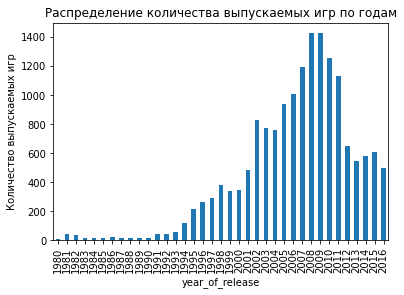

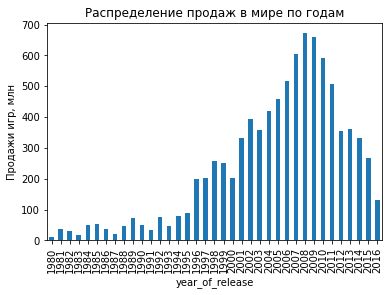

In [13]:
# Зависимость количества выпускаемых игр от года
data.groupby(by="year_of_release").agg("count")["name"].plot.bar().set_title(
    "Распределение количества выпускаемых игр по годам")
plt.ylabel("Количество выпускаемых игр")
plt.show()
data.groupby(by="year_of_release").agg("sum")["total_sales"].plot.bar().set_title(
    "Распределение продаж в мире по годам")
plt.ylabel("Продажи игр, млн")
plt.show()

Из графика видно, что начиная с 1993 года пошел активный выпуск игр, который достиг максимума в 2008-2009 гг., а после начал спадать. Это можно объяснить развитием мобильной индустрии.

### Определение временного интервала и платформ для дальнейшего анализа

In [14]:
# Проверка уникальных платформ, нет ли дубликатов
data["platform"].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [15]:
# Группирование данных по платформам
df = pd.pivot_table(data, 
                    index=["year_of_release","platform"],
                    values=["total_sales"],
                    aggfunc=["sum","count"]).reset_index()
df.columns = ["year_of_release","platform", "sum_total_sales", "amount"]

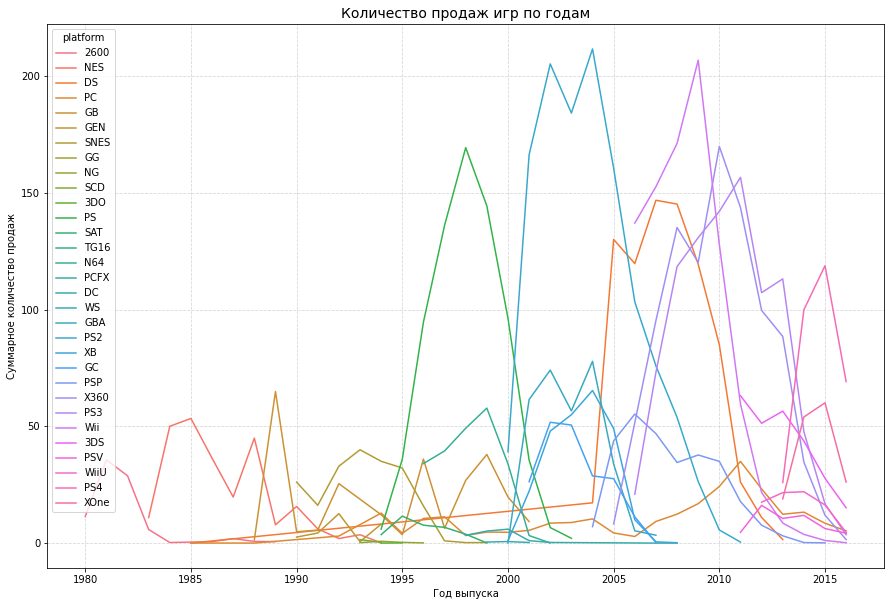

In [16]:
# Нахождение лидирующих по продажам платформ
sns.lineplot(
    data=df, 
    x="year_of_release", 
    y="sum_total_sales", 
    hue="platform").set_title(
    "Количество продаж игр по годам",  fontdict={'fontsize':14})
plt.gcf().set_size_inches(15, 10)
plt.grid(linestyle='--', alpha=0.5)
plt.xlabel("Год выпуска")
plt.ylabel("Суммарное количество продаж")
plt.show()

Проверим игры, у которых помечена платформа DS и которые появились до 2003 г.

In [17]:
df_ds = data.query("platform == 'DS' and year_of_release < 2003")
df_ds

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN,0.02


</font><font color='Blue'>В датафрейме есть одина игра, которая была выпущена до появления платформы, возможно ее просто перенесли с платформ более ранних версий и сохранили год первоначального издания</font><br>

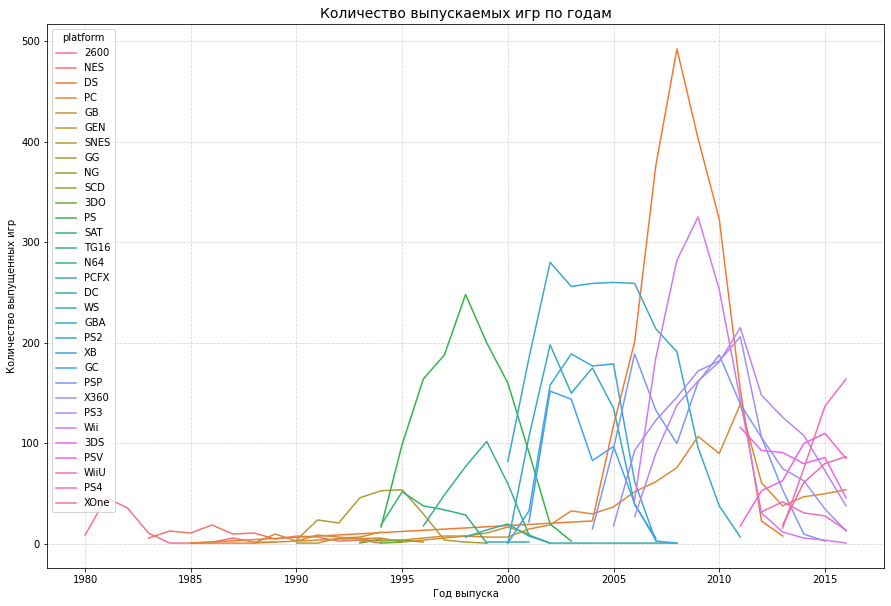

In [18]:
# Нахождение лидирующих по выпуску игр платформ
sns.lineplot(
    data=df, 
    x="year_of_release", 
    y="amount", 
    hue="platform").set_title(
    "Количество выпускаемых игр по годам",  fontdict={'fontsize':14})
plt.gcf().set_size_inches(15, 10)
plt.grid(linestyle='--', alpha=0.5)
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.show()

В среднем платформы "живут" около 10 лет.  

Наиболее актуальными будут данные начиная с 2012 года, т.к. с 2011-2016 количество выпускаемых игр примерно совпадает, следовательно не будет лишних завышений или занижений прогнозных продаж. Такой интервал также связан с тем, что студии начали работать прежде всего на качество игр, следовательно повышения количества выпускаемых игр также не ожидается.  

Для этих годов рассмотрим отдельно продажи и количество выпускаемых игр по платформам DS ,PSP, X360, PS3, Wii, 3DS, PSV, WiiU, PS4, XOne, PC. Возможно часть из них уже не подходит, т.к. продажи или выпуск игр на них падают или прекратились.

In [19]:
df.query("year_of_release >= 2012", inplace=True)
platforms = ["DS","PSP", "X360", "PS3", "Wii", "3DS", "PSV", "WiiU", "PS4", "XOne", "PC"]

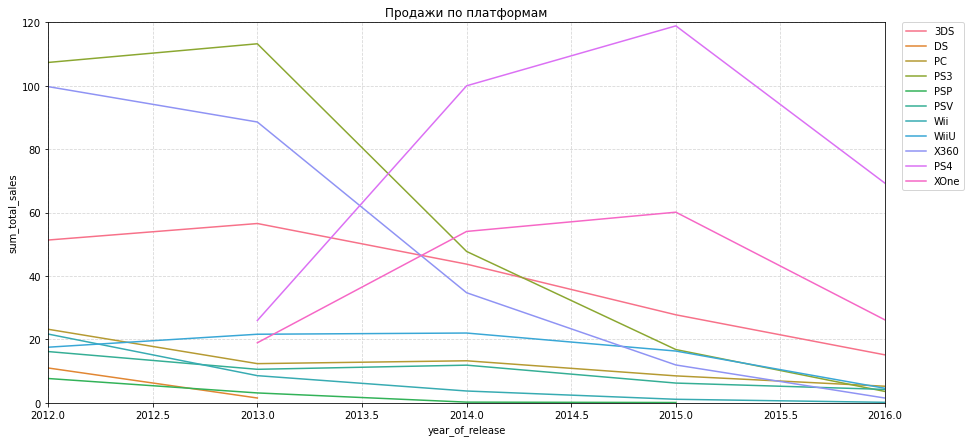

In [20]:
# Построение графиков по продажам
sns.lineplot(
    data=df.query("platform in @platforms"), 
    x="year_of_release", 
    y="sum_total_sales", 
    hue="platform").set_title(
    "Продажи по платформам",  fontdict={'fontsize':12})
plt.gcf().set_size_inches(15, 7)
plt.grid(linestyle='--', alpha=0.5)
plt.ylim([0,120])
plt.xlim([2012,2016])
plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left', borderaxespad= 0 ) 
plt.show()

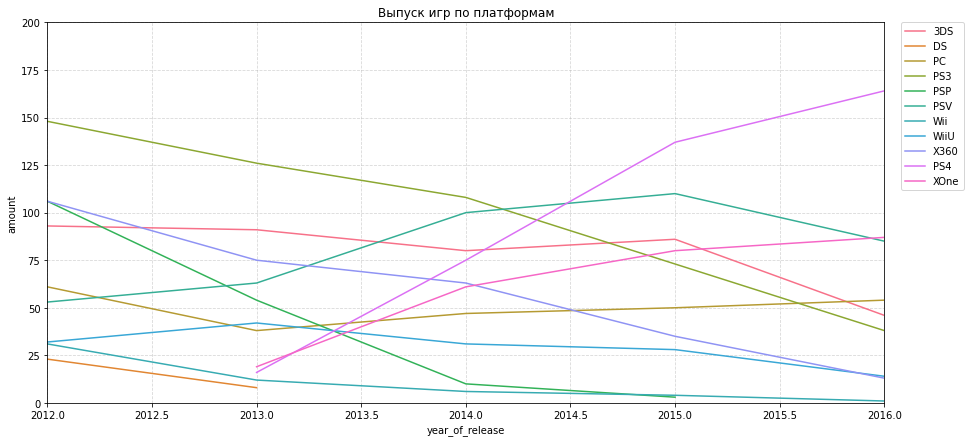

In [21]:
# Построение графиков по выпускаемым играм
sns.lineplot(
    data=df.query("platform in @platforms"), 
    x="year_of_release", 
    y="amount", 
    hue="platform").set_title(
    "Выпуск игр по платформам",  fontdict={'fontsize':12})
plt.gcf().set_size_inches(15, 7)
plt.grid(linestyle='--', alpha=0.5)
plt.ylim([0,200])
plt.xlim([2012,2016])
plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left', borderaxespad= 0 ) 
plt.show()

На платформах DS, PSP, X360, PS3, Wii, WiiU на 2016 продажи и выпуск игр сильно упали  или прекращены. На PSV заметно сильное снижение продаж, начиная с 2015 года, хотя игры до сих пор выпускаются. На платформах PS4, XOne, PC происходит рост продаж игр. На платформе 3DS заметно снижение продаж и выпуска, но показатели еще высоки. Для дальнейшего анализа возьмем четыре платформы: PS4, XOne, PC и 3DS.

In [22]:
int_platforms = ["3DS","PS4", "XOne", "PC"]
df.query("platform in @int_platforms", inplace=True)

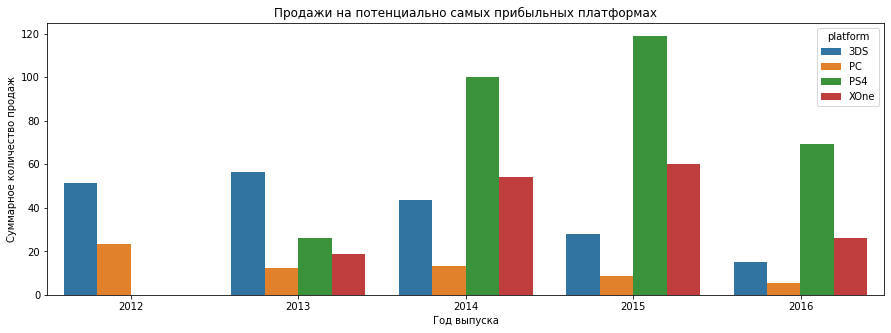

In [23]:
sns.barplot(
    data=df,
    x="year_of_release",
    y="sum_total_sales",
    hue="platform",
    ci=None).set_title("Продажи на потенциально самых прибыльных платформах")
plt.gcf().set_size_inches(15, 5)
plt.xlabel("Год выпуска")
plt.ylabel("Суммарное количество продаж")
plt.show()

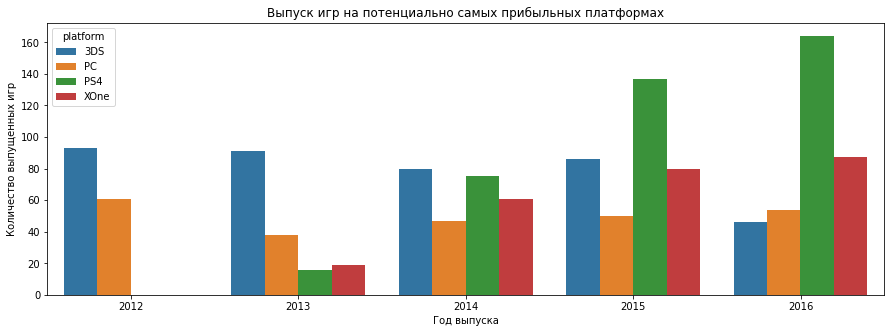

In [24]:
sns.barplot(
    data=df,
    x="year_of_release",
    y="amount",
    hue="platform",
    ci=None).set_title("Выпуск игр на потенциально самых прибыльных платформах")
plt.gcf().set_size_inches(15, 5)
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.show()

Самой прибыльной платформой является PS4, продажи и количество игр на ней растут каждый год. В окончательную обработку для исследовательского анализа данных примем четыре платформы - PS4, XOne, 3DS и PC и временной интервал с 2012 года. Несмотря на малое количество продаж игр для персонального компьютера, оставим эту платформу в связи с тем, что она является традиционной и в ближайшее время точно не исчезнет из жизни. 

### Исследовательский анализ данных для платформ PS4, XOne, PC

In [25]:
# Получение интересующих данных из исходного датафрейма
#int_platforms = ["PS4", "XOne", "PC", "3DS"]
df_1 = data.query("year_of_release >= 2012")
df_1.info()
df_1.head(10)

<class 'pandas.core.frame.DataFrame'>

Int64Index: 2886 entries, 16 to 16714

Data columns (total 12 columns):

 #   Column           Non-Null Count  Dtype  

---  ------           --------------  -----  

 0   name             2886 non-null   object 

 1   platform         2886 non-null   object 

 2   year_of_release  2886 non-null   Int64  

 3   genre            2886 non-null   object 

 4   na_sales         2886 non-null   float64

 5   eu_sales         2886 non-null   float64

 6   jp_sales         2886 non-null   float64

 7   other_sales      2886 non-null   float64

 8   critic_score     1312 non-null   float64

 9   user_score       1531 non-null   float64

 10  rating           1611 non-null   object 

 11  total_sales      2886 non-null   float64

dtypes: Int64(1), float64(7), object(4)

memory usage: 295.9+ KB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
62,New Super Mario Bros. 2,3DS,2012,Platform,3.66,3.14,2.47,0.63,78.0,7.2,E,9.90


In [26]:
df_1.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,2886.000000,2886.000000,2886.000000,2886.000000,2886.000000,1312.000000,1531.000000,2886.000000
mean,2013.916840,0.204771,0.175613,0.066729,0.054109,72.258384,6.636120,0.501223
std,1.411766,0.566696,0.505346,0.241575,0.164639,12.687087,1.569033,1.249157
min,2012.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.200000,0.010000
25%,2013.000000,0.000000,0.000000,0.000000,0.000000,66.000000,5.800000,0.040000
50%,2014.000000,0.030000,0.030000,0.010000,0.010000,74.000000,7.000000,0.120000
75%,2015.000000,0.170000,0.140000,0.050000,0.040000,81.000000,7.800000,0.430000
max,2016.000000,9.660000,9.090000,4.390000,3.960000,97.000000,9.300000,21.050000


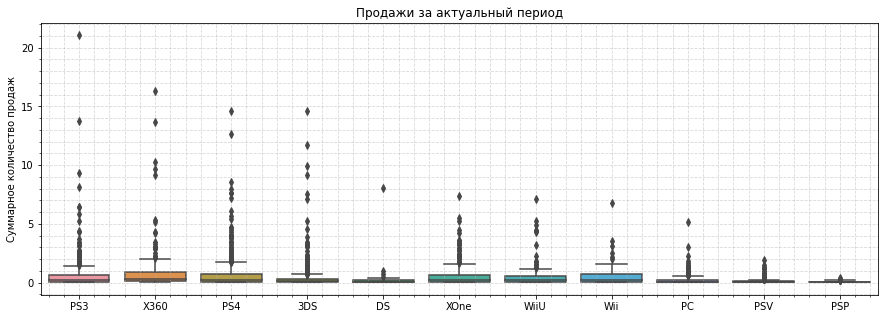

In [27]:
# Построение боксплота по продажам игр для различных платформ
sns.boxplot(data=df_1,
           x="platform",
           y="total_sales").set_title("Продажи за актуальный период")
plt.gcf().set_size_inches(15, 5)
plt.minorticks_on()   
plt.grid(which="both", linestyle='--', alpha=0.5)
plt.xlabel("")
plt.xlabel("")
plt.ylabel("Суммарное количество продаж")
plt.show()

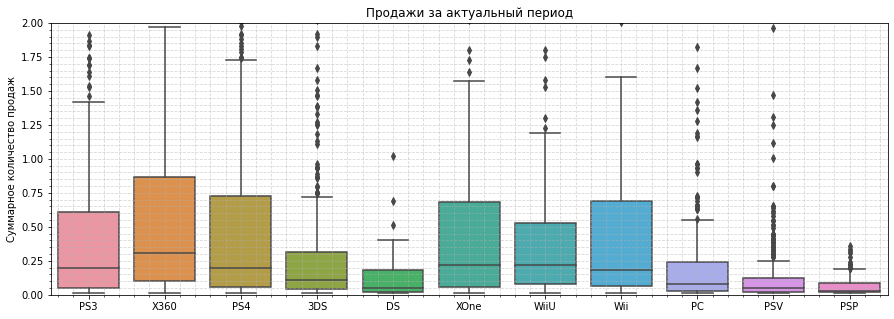

In [28]:
# Построение боксплота по продажам игр для различных платформ без учета года выпуска игры
sns.boxplot(data=df_1,
           x="platform",
           y="total_sales"
           ).set_title("Продажи за актуальный период")
plt.gcf().set_size_inches(15, 5)
plt.minorticks_on()   
plt.grid(which="both", linestyle='--', alpha=0.5)
plt.xlabel("")
plt.ylabel("Суммарное количество продаж")
plt.ylim([0,2])
plt.show()

</font><font color='Blue'>Самые высокие медианные продажи наблюдаются на платформе X360, следующая по продажам PS4. Самые продаваемые игры находятся на платформе PS3, далее по убыванию продаж расположены X360, PS4, 3DS.</font><br>

#### Исследование корреляции оценок критиков и пользователей и продаж

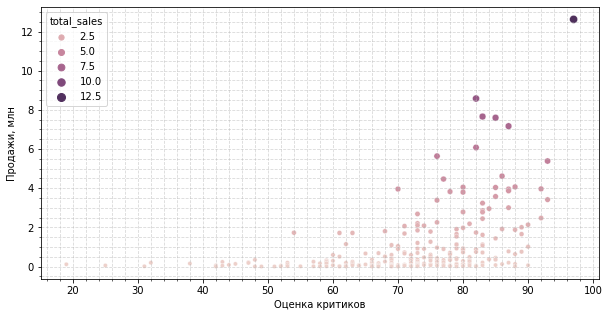

In [29]:
# Проверка коррелиированности оценки критиков и продаж игр
sns.scatterplot(
    data=df_1.loc[data["platform"] == "PS4"], 
    x="critic_score", 
    y="total_sales", 
    hue="total_sales",
    size="total_sales",
    s=12,
    alpha=1)
plt.gcf().set_size_inches(10, 5)
plt.minorticks_on()
plt.grid(which="both", linestyle='--', alpha=0.5)
plt.xlabel("Оценка критиков")
plt.ylabel("Продажи, млн")
plt.show()

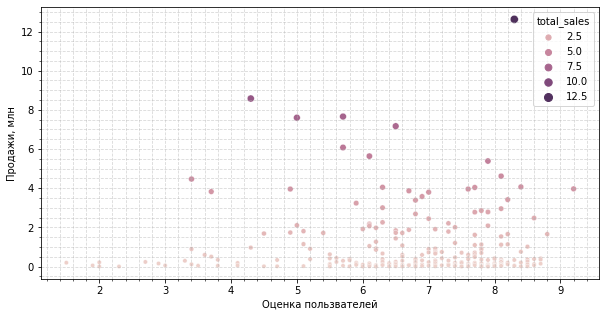

In [30]:
# Проверка коррелиированности оценки пользователей и продаж игр
sns.scatterplot(
    data=df_1.loc[data["platform"] == "PS4"], 
    x="user_score", 
    y="total_sales", 
    hue="total_sales",
    size="total_sales",
    s=12,
    alpha=1)
plt.gcf().set_size_inches(10, 5)
plt.minorticks_on()
plt.grid(which="both", linestyle='--', alpha=0.5)
plt.xlabel("Оценка пользвателей")
plt.ylabel("Продажи, млн")
plt.show()

Для платформы PS4 наблюдается зависимость продажи игры от оценки критиков или пользователей. При этом на пользовательском графике видны несколько игр, которые имеют высокие продажи, но среднюю оценку. У значительного количства игр высокие баллы, но малые продажи.  

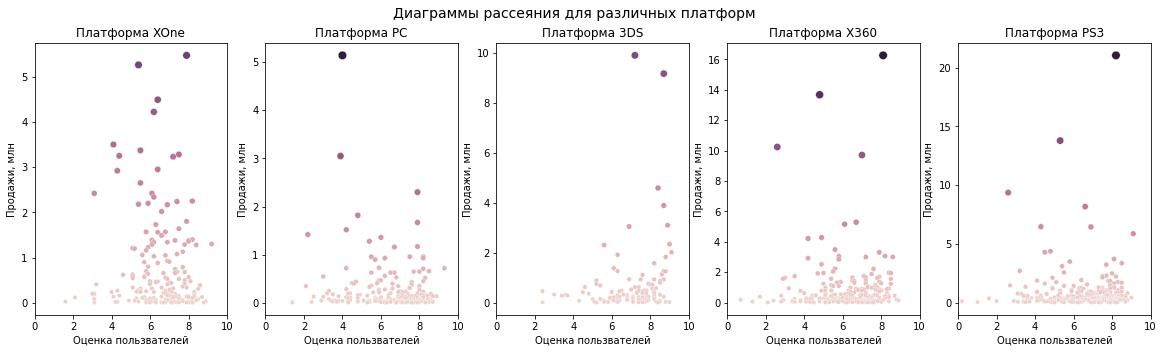

In [31]:
t_platforms = ["XOne", "PC","3DS", "X360", "PS3"]
i = 0
for plat in t_platforms:
    i += 1
    plt.subplot(1,5,i)
    sns.scatterplot(data = df_1.loc[data["platform"] == plat], 
                    x="user_score", 
                    y="total_sales", 
                    hue="total_sales",
                    size="total_sales",
                    legend=False,
                    s=12,
                    alpha=1).set_title(f"Платформа {plat}")
    plt.suptitle("Диаграммы рассеяния для различных платформ", fontsize=14)
    plt.gcf().set_size_inches(20, 5)
    plt.xlim([0,10])
    plt.xlabel("Оценка пользвателей")
    plt.ylabel("Продажи, млн")
    
    
plt.show()

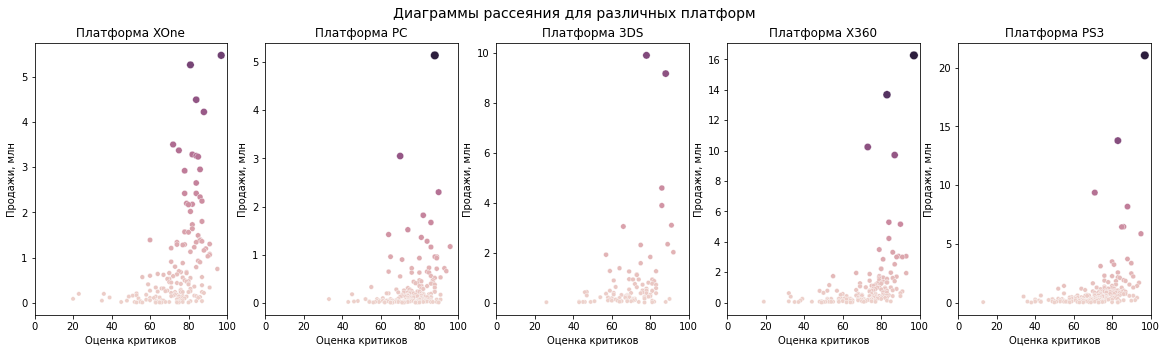

In [32]:
t_platforms = ["XOne", "PC","3DS", "X360", "PS3"]
i = 0
for plat in t_platforms:
    i += 1
    plt.subplot(1,5,i)
    sns.scatterplot(data = df_1.loc[data["platform"] == plat], 
                    x="critic_score", 
                    y="total_sales", 
                    hue="total_sales",
                    size="total_sales",
                    legend=False,
                    s=12,
                    alpha=1).set_title(f"Платформа {plat}")
    plt.suptitle("Диаграммы рассеяния для различных платформ", fontsize=14)
    plt.gcf().set_size_inches(20, 5)
    plt.xlim([0,100])
    plt.xlabel("Оценка критиков")
    plt.ylabel("Продажи, млн")
    
    
plt.show()

Примерно у четверти игр нет оценок критиков и/или пользователей, следовательно, не будет данных для расчета корреляции. Поэтому велична выборки будет расчитывать без учета строк, содержащих значение NaN.

Размер выборки: 249


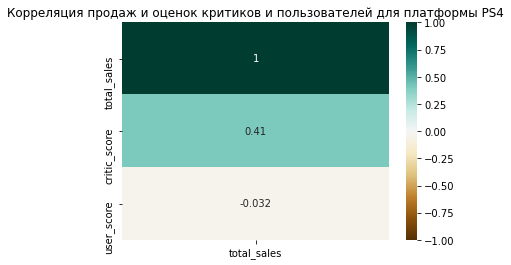

Размер выборки: 165


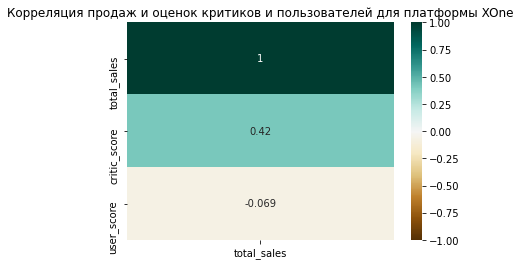

Размер выборки: 197


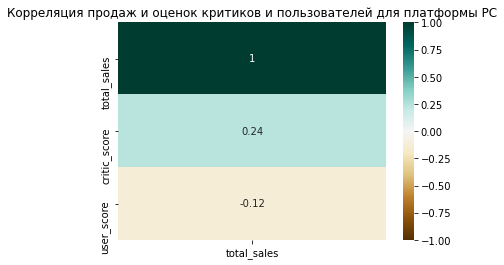

Размер выборки: 100


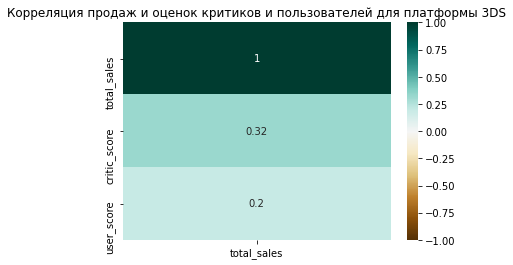

Размер выборки: 171


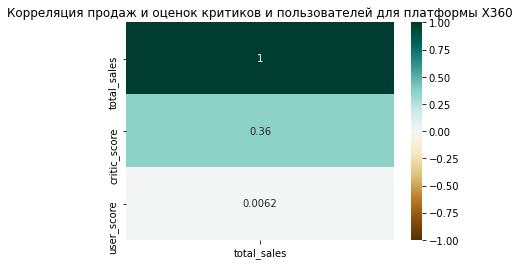

Размер выборки: 213


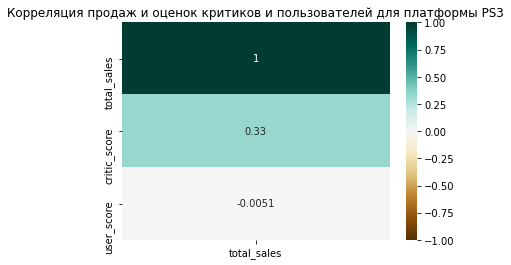

In [33]:
# Корреляция Пирсона для самых продаваемых игр
df_2 = df_1[["platform","critic_score","user_score","total_sales"]]
int_platforms = ["PS4", "XOne", "PC","3DS", "X360", "PS3"]
for name in int_platforms:
    print("Размер выборки:",df_2[df_2["platform"] == name].dropna().shape[0])
    sns.heatmap(
    df_2[df_2["platform"] == name].corr()[["total_sales"]].sort_values(by="total_sales", ascending=False),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap='BrBG').set_title(
    f"Корреляция продаж и оценок критиков и пользователей для платформы {name}",  fontdict={'fontsize':12})
    plt.show()

В целом можно сделать вывод, что успех продаж сильнее зависит от оценок критиков, а не пользователей. Однако корреляционная связь все равно слабая. Большая зависимость от оценок критиков может быть объяснена, что при покупке человек ориентируется на них, а уже после приобретения игры выставляет свою оценку.

#### Исследование корреляции жанра игры и продаж

In [34]:
# Комментарий ревьюера
temp1, temp2 = data.query("platform in @int_platforms and year_of_release >= 2012").total_sales.sum(),\
data[data.year_of_release >= 2012].total_sales.sum()
temp1, temp2, round((temp2-temp1)/temp2*100, 2)

(1256.05, 1446.5300000000002, 13.17)

In [35]:
df_4 = df_1.groupby(by="genre").agg(["count","sum","mean"])["total_sales"].reset_index()
df_4.sort_values(by="mean")

,genre,count,sum,mean
1,Adventure,302,29.43,0.097450
5,Puzzle,28,4.89,0.174643
11,Strategy,71,13.34,0.187887
2,Fighting,109,44.49,0.408165
0,Action,1031,441.12,0.427856
9,Simulation,80,35.12,0.439000
3,Misc,192,85.04,0.442917
6,Racing,115,53.50,0.465217
7,Role-Playing,370,192.80,0.521081
10,Sports,268,181.07,0.675634


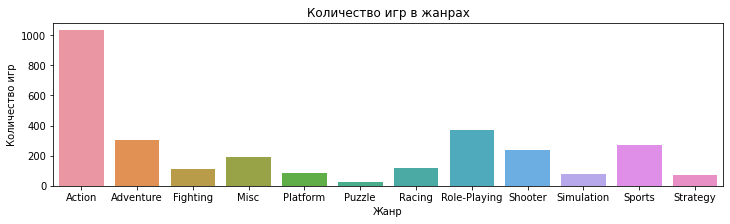

In [36]:
sns.barplot(
    data=df_4,
    x="genre",
    y="count",
    ci=None).set_title("Количество игр в жанрах")
plt.gcf().set_size_inches(12, 3)
plt.xlabel("Жанр")
plt.ylabel("Количество игр")
plt.show()

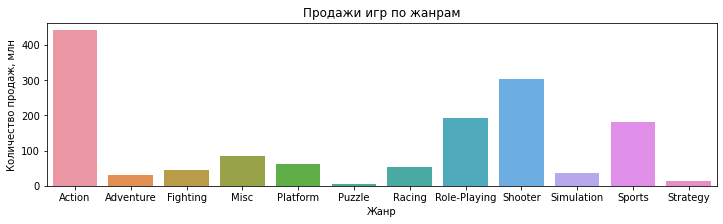

In [37]:
sns.barplot(
    data=df_4,
    x="genre",
    y="sum",
    ci=None).set_title("Продажи игр по жанрам")
plt.gcf().set_size_inches(12, 3)
plt.xlabel("Жанр")
plt.ylabel("Количество продаж, млн")
plt.show()

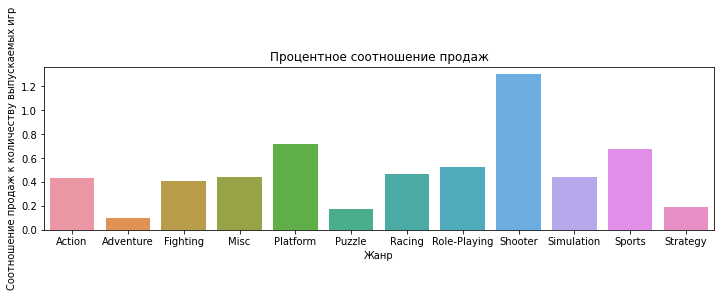

In [38]:
# Сколько продож приходится на одну игру
sns.barplot(
    data=df_4,
    x="genre",
    y="mean",
    ci=None).set_title("Процентное соотношение продаж")
plt.gcf().set_size_inches(12, 3)
plt.xlabel("Жанр")
plt.ylabel("Соотношение продаж к количеству выпускаемых игр")
plt.show()

Как видно, самыми продаваемыми играми экшены, но только потому, что их больше всего производят.  
Если смотреть только относительное число продаж, то лидирующими жанрами являются шутеры и спорт. Примерно одинаковое соотношение продаж к выпуску имеют следующие жанры: экшены, файтинги, платформеры, ролевые игры.  
Жанры с самыми низкими продажами и выпуском являются платформеры, файтинги, головоломки, стратегии, приключенческие игры.  
Найдем корреляцию между жанром игры и ее продажами для игр, продажи которых не считаюся выбросами (определенными в п. 3.2.1).  
Также видно, что топ рейтинга занимают всемирно известные серии игры.

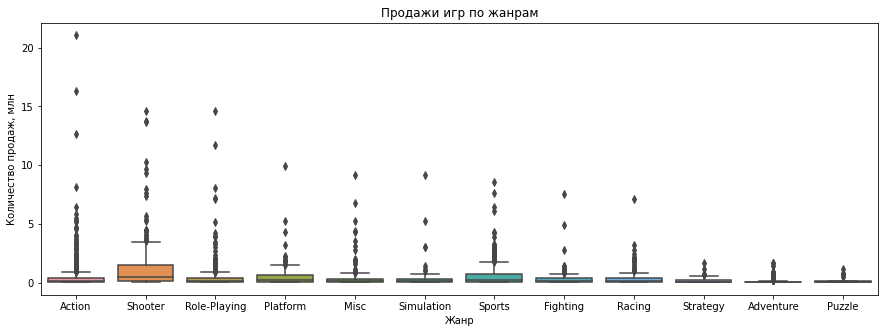

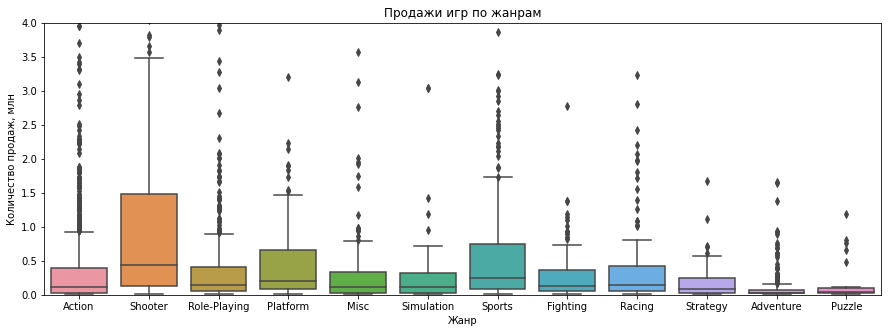

In [39]:
sns.boxplot(
    data=df_1,
    x="genre",
    y="total_sales").set_title("Продажи игр по жанрам")
plt.gcf().set_size_inches(15, 5)
plt.xlabel("Жанр")
plt.ylabel("Количество продаж, млн")
plt.show()

sns.boxplot(
    data=df_1,
    x="genre",
    y="total_sales").set_title("Продажи игр по жанрам")
plt.gcf().set_size_inches(15, 5)
plt.xlabel("Жанр")
plt.ylim([0,4])
plt.ylabel("Количество продаж, млн")
plt.show()

 В жанре экшен много успешных игр, однако медианное значение продаж находится на том же уровне, что и ролевые игры, симуляторы, файтинги, гонки и других жанров. Наибольшее медианное значение продаж приходится на шутеры, на втором месте ролевые игры.

In [40]:
df_5 = df_1.dropna(subset=["genre"])
df_5.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


In [41]:
# Корреляция Спирмена. Нулевая гипотеза - корреляционной зависимости нет
print("Размер выборки:", df_5.shape[0])
rho, p = spearmanr(df_5["total_sales"], df_5["genre"])
if p < 0.05:
    print(f"Коэффциент корреляции {rho.round(2)}. Гипотеза о некоррелированности выборок подтвердилась на уровне значенимости 5%.")
else:
    print(f"Коэффциент корреляции {rho.round(2)}. Гипотеза о некоррелированности выборок отвергнута на уровне значенимости 5%.")

Размер выборки: 2886

Коэффциент корреляции 0.15. Гипотеза о некоррелированности выборок подтвердилась на уровне значенимости 5%.


/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.

  warnings.warn("The input array could not be properly "


Хотя среди жанров есть лидеры по продажам, одназначно установить связь между жанром и успехом продажи игры нельзя. 

## Составьте портрет пользователя каждого региона

Для нахождения зависимостей рассмотрим платформы, которые еще "живы" на 2016 г: "PSP", "X360", "PS3", "Wii", "3DS", "PSV", "WiiU", "PS4", "XOne", "PC", т.к. остальная информация просто не актуальна.

In [42]:
platforms = ["PSP", "X360", "PS3", "Wii", "3DS", "PSV", "WiiU", "PS4", "XOne", "PC"]
df = data.query("platform in @platforms and year_of_release >= 2012")

df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


### Определение самых популярных платформ по регионам NA, EU, JP

In [43]:
df_1 = pd.pivot_table(df, 
                      index=["platform"], 
                      values=["na_sales","eu_sales","jp_sales"],
                      aggfunc="sum").reset_index()
df_1

,platform,eu_sales,jp_sales,na_sales
0,3DS,42.64,87.79,55.31
1,PC,37.76,0.00,19.12
2,PS3,106.86,35.29,103.38
3,PS4,141.09,15.96,108.74
4,PSP,0.42,10.47,0.13
5,PSV,11.36,21.04,10.98
6,Wii,11.92,3.39,17.45
7,WiiU,25.13,13.01,38.10
8,X360,74.52,1.57,140.05
9,XOne,51.59,0.34,93.12


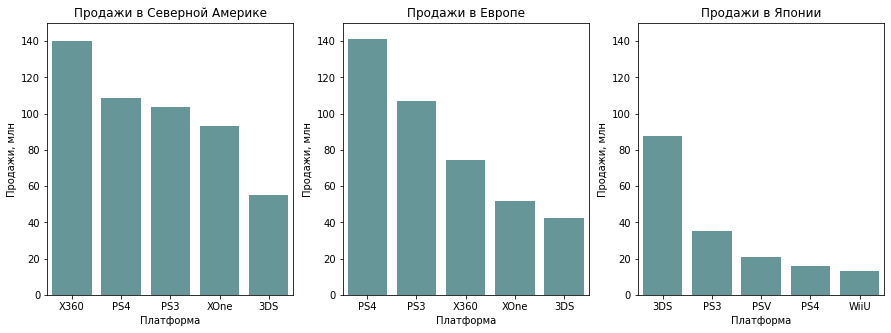

In [44]:
title_dict = {"na_sales": "Продажи в Северной Америке",
               "eu_sales": "Продажи в Европе",
               "jp_sales": "Продажи в Японии"}
regions = ["na_sales", "eu_sales", "jp_sales"]
i = 0
for region in regions:
    i += 1
    plt.subplot(1,3,i)
    sns.barplot(data = df_1.sort_values(by=region, ascending=False).head(),
               x="platform",
               y=region,
               color="cadetblue").set_title(title_dict[region])
    plt.gcf().set_size_inches(15, 5)
    plt.ylim([0,150])
    plt.xlabel("Платформа")
    plt.ylabel("Продажи, млн")
    
    
plt.show()
    


В Северной Америке (СА) и Европе самыми популярными платформами являются Xbox, PS и 3DS. В топе-5 у этих регионов одни и те же платформы.   
В Японии преобладают местные портативные консоли и платформы PS.

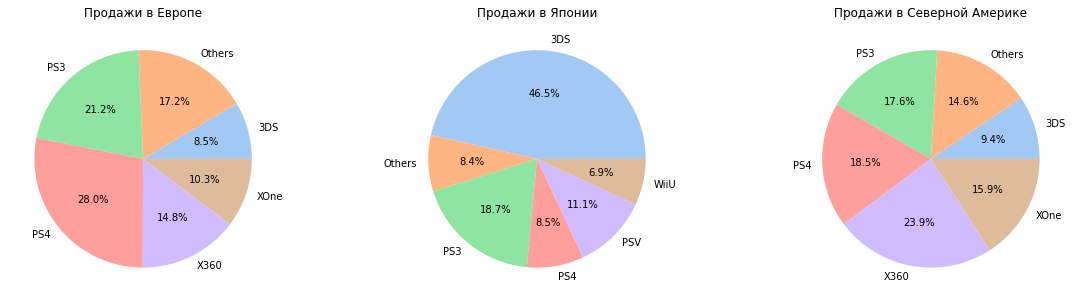

In [45]:
NA = ["X360","PS4","PS3","XOne","3DS"]
EU = ["X360","PS4","PS3","XOne","3DS"]
JP = ["WiiU","PS4","PS3","PSV","3DS"]
title_dict = {"na_sales": "Продажи в Северной Америке",
               "eu_sales": "Продажи в Европе",
               "jp_sales": "Продажи в Японии"}
colors = sns.color_palette('pastel')[0:6]
regions = [EU, JP, NA]
i = 0
for r_sales in df_1.columns[1:4]:
    temp_plat = df_1.copy(deep=True)
    temp_plat.loc[~temp_plat["platform"].isin(regions[i]),"platform"] ="Others"
    temp_plat = temp_plat.groupby(by="platform").agg("sum").reset_index()
    plt.subplot(1,3,i+1)
    plt.pie(
        temp_plat[r_sales], 
        labels=temp_plat["platform"], 
        colors=colors, autopct='%1.1f%%')
    plt.title(title_dict[r_sales])
    plt.gcf().set_size_inches(20, 5)
    i += 1


Выведем год появления платформ, чтобы определить наиболее актуальные из них.

In [46]:
platforms = ["PSP", "X360", "PS3", "Wii", "3DS", "PSV", "WiiU", "PS4", "XOne", "PC"]
for plat in platforms:
    df_0 = data[data["platform"] == plat]
    print(f"Год появления платформы {plat}:", df_0["year_of_release"].min())

Год появления платформы PSP: 2004

Год появления платформы X360: 2005

Год появления платформы PS3: 2006

Год появления платформы Wii: 2006

Год появления платформы 3DS: 2011

Год появления платформы PSV: 2011

Год появления платформы WiiU: 2012

Год появления платформы PS4: 2013

Год появления платформы XOne: 2013

Год появления платформы PC: 1985


###  Определение самых популярных жанров по регионам NA, EU, JP

In [47]:
df_2 = pd.pivot_table(df, 
                      index=["genre"], 
                      values=["na_sales","eu_sales","jp_sales"],
                      aggfunc="sum").reset_index()
df_2

,genre,eu_sales,jp_sales,na_sales
0,Action,158.63,52.60,177.05
1,Adventure,9.41,8.23,8.92
2,Fighting,10.79,9.44,19.79
3,Misc,25.95,12.86,38.13
4,Platform,20.98,8.63,25.17
5,Puzzle,1.31,2.14,1.13
6,Racing,27.29,2.50,17.22
7,Role-Playing,46.76,61.93,60.65
8,Shooter,113.47,9.23,144.77
9,Simulation,14.47,10.41,7.86


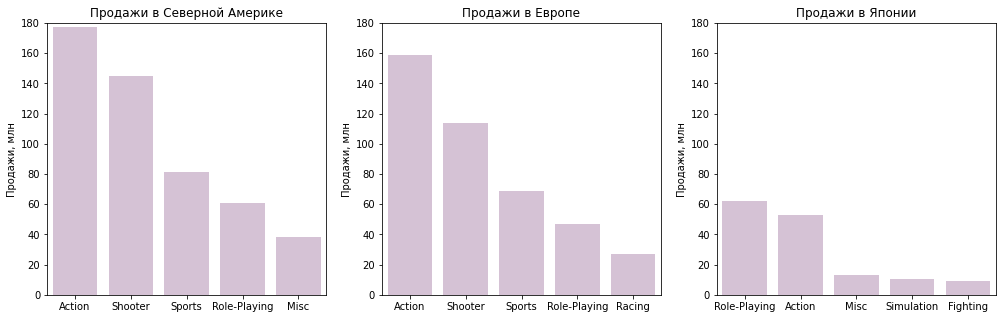

In [48]:
title_dict = {"na_sales": "Продажи в Северной Америке",
               "eu_sales": "Продажи в Европе",
               "jp_sales": "Продажи в Японии"}
regions = ["na_sales", "eu_sales", "jp_sales"]
i = 0
for region in regions:
    i += 1
    plt.subplot(1,3,i)
    sns.barplot(data = df_2.sort_values(by=region, ascending=False).head(),
               x="genre",
               y=region,
               color="thistle").set_title(title_dict[region])
    plt.gcf().set_size_inches(17, 5)
    plt.ylim([0,180])
    plt.xlabel("")
    plt.ylabel("Продажи, млн")
    
    
plt.show()

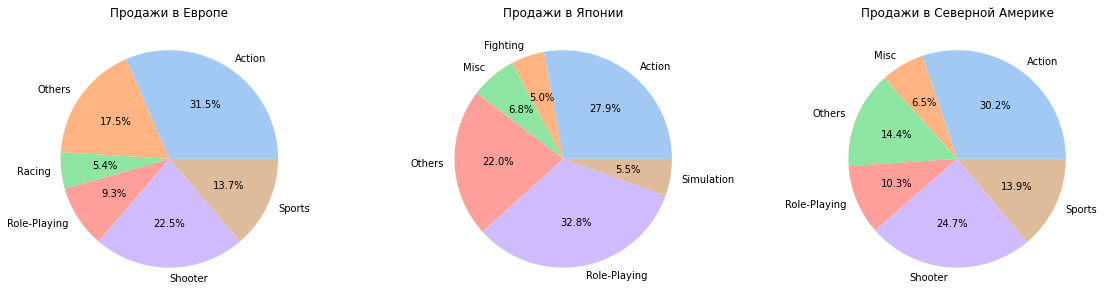

In [49]:
NA = ["Action","Shooter","Sports","Role-Playing","Misc"]
EU = ["Action","Shooter","Sports","Role-Playing","Racing"]
JP = ["Fighting","Simulation","Action","Role-Playing","Misc"]
title_dict = {"na_sales": "Продажи в Северной Америке",
               "eu_sales": "Продажи в Европе",
               "jp_sales": "Продажи в Японии"}
colors = sns.color_palette('pastel')[0:6]
regions = [EU, JP, NA]
i = 0
for r_sales in df_2.columns[1:4]:
    temp_plat = df_2.copy(deep=True)
    temp_plat.loc[~temp_plat["genre"].isin(regions[i]),"genre"] ="Others"
    temp_plat = temp_plat.groupby(by="genre").agg("sum").reset_index()
    plt.subplot(1,3,i+1)
    plt.pie(
        temp_plat[r_sales], 
        labels=temp_plat["genre"], 
        colors=colors, autopct='%1.1f%%')
    plt.title(title_dict[r_sales])
    plt.gcf().set_size_inches(20, 5)
    i += 1

###  Проверка влияния рейтинга ESRB на продажи в отдельном регионе

In [50]:
# Получение всех возможных рейтингов
df["rating"].unique()

array(['M', nan, 'E', 'E10+', 'T'], dtype=object)

In [51]:
# Расшифровка рейтинга для облегчения понимания
rating_dict = {"M": "Для взрослых",
               "E": "Для всех",
               "E10+": "От 10 лет и старше",
               "T": "Подросткам",
               "Рейтинг не установлен": "Рейтинг не установлен"}
df_3 = df.copy(deep=True)
df_3["rating"] = df["rating"].fillna("Рейтинг не установлен")
df_3 = pd.pivot_table(df_3, 
                      index=["rating"], 
                      values=["na_sales","eu_sales","jp_sales"],
                      aggfunc="sum").reset_index()

df_3["rating_descr"] = df_3["rating"].map(rating_dict)
df_3

,rating,eu_sales,jp_sales,na_sales,rating_descr
0,E,112.21,27.96,113.57,Для всех
1,E10+,54.84,8.19,75.09,От 10 лет и старше
2,M,193.96,21.20,231.57,Для взрослых
3,T,52.96,26.02,66.02,Подросткам
4,Рейтинг не установлен,89.32,105.49,100.13,Рейтинг не установлен


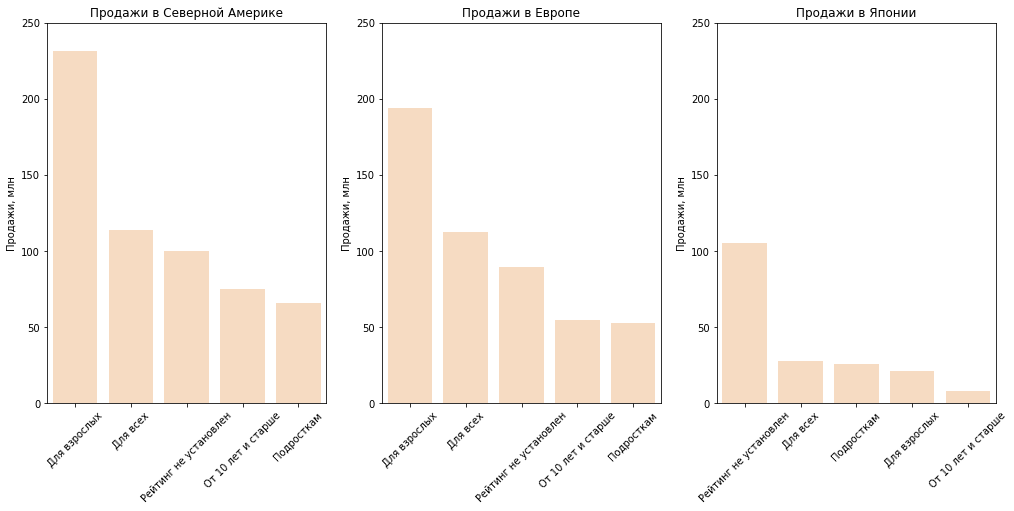

In [52]:
title_dict = {"na_sales": "Продажи в Северной Америке",
               "eu_sales": "Продажи в Европе",
               "jp_sales": "Продажи в Японии"}
regions = ["na_sales", "eu_sales", "jp_sales"]
i = 0
for region in regions:
    i += 1
    plt.subplot(1,3,i)
    sns.barplot(data = df_3.sort_values(by=region, ascending=False).head(),
               x="rating_descr",
               y=region,
               color="peachpuff").set_title(title_dict[region])
    plt.gcf().set_size_inches(17, 7)
    plt.ylim([0,250])
    plt.xlabel("")
    plt.xticks(rotation=45)
    plt.ylabel("Продажи, млн")
    
    
plt.show()

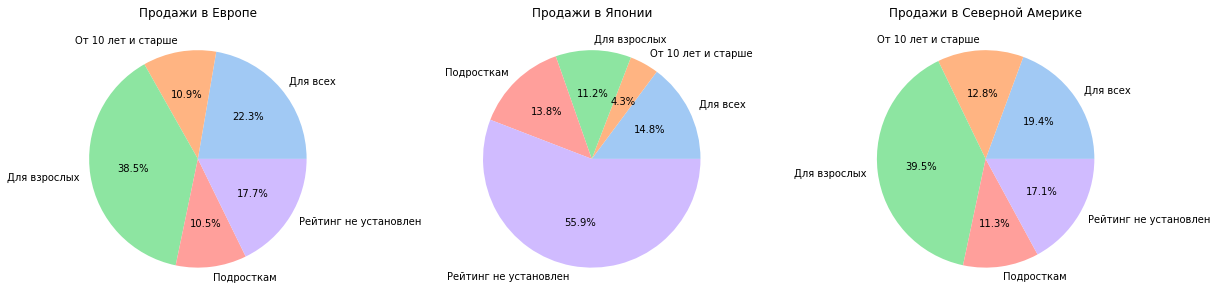

In [53]:
colors = sns.color_palette('pastel')[0:6]
i = 0
for r_sales in df_3.columns[1:4]:
    temp_plat = df_3.copy(deep=True)
    plt.subplot(1,3,i+1)
    plt.pie(
        temp_plat[r_sales], 
        labels=temp_plat["rating_descr"], 
        colors=colors, autopct='%1.1f%%')
    plt.title(title_dict[r_sales])
    plt.gcf().set_size_inches(20, 5)
    i += 1

Опять же, для СА и Европы наблюдается согласованность в продажах - лидируют игры для взрослых, наименее продаваемые - для подростокв. Однако для двух возрастных групп - "10+", подростки не такой большой разрыв.  
В Японии лидером являются игры для всех, второе место - для подростков. Это коррелирует с тем, что японцы предпочитают портативные консоли, которые дешевле и могут позволить себе даже дети.

In [54]:
# Комментарий ревьюера
temp = data[data.year_of_release >= 2012].copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts()

1275 0.4417879417879418


M       498
T       412
E       395
E10+    306
Name: rating, dtype: int64

## Проверьте гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза состоит в том, что средние рейтинги платформ одинаковые. Альтернативная - разные. Выберем уровень значимости 5%.

In [55]:
df_hyp = data.query("year_of_release >= 2012")

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, правильно сформулированы гипотезы.</font>

In [56]:
x_one_r = df_hyp.loc[df_hyp["platform"] == "XOne"]["user_score"].dropna()
pc_r = df_hyp.loc[df_hyp["platform"] == "PC"]["user_score"].dropna()
print(f"Дисперсия рейтингов Xbox One: {np.std(x_one_r)}")
print(f"Дисперсия рейтингов PC: {np.std(pc_r)}")

Дисперсия рейтингов Xbox One: 1.377141546212499

Дисперсия рейтингов PC: 1.660420199796021


In [57]:
# Выборки имеют примерно равную дисперсию, поэтому применяем двухвыборочный t-критерий
alpha = 0.05
stat, p = ttest_ind(x_one_r, pc_r)
print(f"t-тестовая статистика: {stat.round(2)}, p-value: {p.round(5)}")
if p < alpha:
    print(f"Нулевая гипотеза о равенстве средних рейтингов отклонена на уровне значимости {alpha}")
else:
    print(f"Нулевая гипотеза о равенстве средних рейтингов принята на уровне значимости {alpha}")

t-тестовая статистика: 0.59, p-value: 0.55351

Нулевая гипотеза о равенстве средних рейтингов принята на уровне значимости 0.05


Средний на этих платформах за период 2012-2016 одинаковый.

In [58]:
print(f"Средний пользовательский рейтинг Xbox One: {x_one_r.mean().round(1)}")
print(f"Средний пользовательский рейтинг PC: {pc_r.mean().round(1)}")

Средний пользовательский рейтинг Xbox One: 6.5

Средний пользовательский рейтинг PC: 6.4


### Средние пользовательские рейтинги жанров Action и Sports разные

Нулевая гипотеза состоит в том, что средние рейтинги платформ равны. Альтернативная - разные. Выберем уровень значимости 5%.

In [59]:
action_r = df_hyp.loc[df_hyp["genre"] == "Action"]["user_score"].dropna()
sports_r = df_hyp.loc[df_hyp["genre"] == "Sports"]["user_score"].dropna()
print(f"Дисперсия рейтингов жанра экшен: {np.std(action_r)}")
print(f"Дисперсия рейтингов спортивного жанра: {np.std(sports_r)}")

Дисперсия рейтингов жанра экшен: 1.373124915673706

Дисперсия рейтингов спортивного жанра: 1.7341823137066392


In [60]:
# Выборки имеют примерно равную дисперсию, поэтому применяем двухвыборочный t-критерий
alpha = 0.05
stat, p = ttest_ind(action_r, sports_r)
print(f"t-тестовая статистика: {stat.round(2)}, p-value: {p.round(5)}")
if p < alpha:
    print(f"Нулевая гипотеза о равенстве средних рейтингов отклонена на уровне значимости {alpha}")
else:
    print(f"Нулевая гипотеза о равенстве средних рейтингов принята на уровне значимости {alpha}")

t-тестовая статистика: 11.01, p-value: 0.0

Нулевая гипотеза о равенстве средних рейтингов отклонена на уровне значимости 0.05


In [61]:
print(f"Средний пользовательский рейтинг жанра экшен: {action_r.mean().round(1)}")
print(f"Средний пользовательский рейтинг спортивного жанра: {sports_r.mean().round(1)}")

Средний пользовательский рейтинг жанра экшен: 6.8

Средний пользовательский рейтинг спортивного жанра: 5.5


Статистически рейтинг у игр жанра экшен выше, чем у спортивных игр по оценкам пользователей.

## Общий вывод

В работе были выполнены следующие задачи:
1. Изучен исходный датафрейм, в котором представленны следующие данные: названия игр, год релиза, жанр, игровая платформа, продажи по регионам (СА, Европа, Япония и другие), оценки пользователей и критиков, рейтинг игр по данным ESRB. Следует отметить, что восстановление данных в данном датафрейме по содержанию других колонок не представляется возможным. 
2. Выявлены и обработаны следующие пропуски в датафрейме:  
  2.1. две игры с пропусками в названии и жанре были удалены;  
  2.2. все игры без года релиза были удалены, т.к. это одна из основных метрик, без которой информация не несет смысла;  
  2.3. пропуски в столбцах с оценками критиков и пользователей оставлены без изменеий;
  2.4. пропуски в возростном рейтинге оставлены замены на "Рейтинг не определен".
  В п.2.1 и 2.2. пропуски могли возникнуть при ошибки выгрузки или заполнении данных об игре. В п.2.3 пропуски могли возникнуть просто потому, что эти игры никто еще не оценил. В п.2.4. пропуски могли возникнуть потому, что рейтинг появлися позже релиза игр или же возрастной ценз оценен в другой системе.
3. Был проведен исследовательский анализ данных:  
  3.1. определено, что количество выпускаемых игр увеличивалось до 2008 года, наибольшее количество выпуска пришлось на 2009 и 2010 гг., после начался спад. Примерно равное количество игр выпускалось в период 2012-2016 гг. Актуальным периодом выбран 2012-2016 гг.;  
  3.2. определно, что средний срок жизни игровой платформы 10 лет, однако персональные компьютеры являются актуальной патформой с 1985 г.;  
  3.3. выявлены платформы, на которые выпускалось наибольшее количество игр в последнее время: DS ,PSP, X360, PS3, Wii, 3DS, PSV, WiiU, PS4, XOne, PC.  
  Исследование этих платформ в разрезе 2012-2016 гг. дало следующий результат: на платформах DS, PSP, X360, PS3, Wii, 3DS, WiiU на 2016 продажи и выпуск игр упали практически до 0 или прекращены. На PSV заметно сильное снижение продаж, начиная с 2015 года, хотя игры до сих пор выпускаются. На платформах PS4, XOne, PC происходит рост выпуска игр и продаж. Самыми продаваемые игры представлены на PS4;  
  3.4. определено, что на покупку игры сильнее влияют отзывы критиков, а не пользователей, т.е. в первую очередь покупаели ориентируются на них;  
  3.5. зависимости оценки критиков от жанра игры не было выявлено.  
4. Был составлен портрет среднего пользователя по крупным регионам продаж (СА, Европа, Япония)  
  4.1. Наиболее популярные жанры игр в регионах по рейтенгу

  | Жанр | Северная Америка | Европа | Япония |
| --- | --- | --- | --- |
| Action | 1 | 1 |  2 |
| Shooter | 2 | 2 |   | 
| Role-Playing | 4 | 4 |  1 |
| Misc | 5 |   |  3 |
| Raicing |  | 5 |   |
| Fighting |  |  |  5 |
| Sports | 3 | 3 |   |
| Simulation |  |  |  4 | 

  В СА и Европе вкусы на игры схожи, в Японии преобладают другие жанры. Также в Японии в топе-5 представлены жанры, которых нет в СА и Европе - симуляторы и файтинги. Рынок СА и ЕВропы перекрывает по продажам Японию, поэтому следует сделать упор на их топ-5. Также стоит отметить, что медианное количество продаж для шутеров выше, а экшены выигрывают за счет количества выпуска и популярных серий игр.
  4.2. Наиболее популярные игровые платформы по регионам с учетом года их появления
   | Платформа | Год поялвения | Северная Америка | Европа | Япония |
| --- | --- | --- | --- | --- |
| X360 | 2005 | 1 |  3 |  |
| XOne | 2013 | 4 | 4 |  |
| PS4 | 2013 | 2 |  1 |  4 |
| PS3 | 2006 | 3  |  2 |  2 |
| PSV | 2011 |  |   |  3 |
| 3DS | 2011 | 5 |  5 | 1 |
| WiiU | 2012 |  |   |  5 |

   В СА, Японии и Европе в топе-5 присутствуют платформы прошлого поколения: X360 и PS3, однако для них наблюдется снижение производства игр. В Японии покупают игры в основном на мобильные консоли - PSV, WiiU, 3DS. Упор в продажах следует сделать на консоли новго поколения - XOne, 3DS и PS4, однако не стоит убирать и игры на прошлые поколения, хотя выпуск игр на них скоро прекратится.  
   4.3. Проверка на предпочтение игр по рейтингу показала, что в СА и Европе предпочитают игры для взрослых, наибльшие продажи в Японии наблюдаются для игр, рейтинг которых не установле ESRB. Две группы - "для взрослых" и "для всех" состовляют основной объем продаж по миру. В Японии преобладают игры у которых нет рейтина ESRB.
5. Было исследованы средние пользовательские рейтинги игр для XOne и PC - расчет показал, что компьютерный игры в среднем получают одинаковые оценки.
6. Были исследованы средние пользовательские рейтинги игр жанров экшен и спорт - расчет показал, что средний рейтинг этих жанров отличается, экшен-игры получают оценку выше.

**Выводы**: ориентироваться следует прежде всего на игры для взрослых или для всех с высокими оценками критиков, упор сделать на жанры экшен и шутеры. Наилучшим образом продаются всемирно известные серии игр вне зависимости от жанра. Наиболее актуальными в будущем будут платформы PC (как традиционная платформа, которая не устареет), XOne, 3DS и PS4. 
  